Create a SLP project using labeled frames from from Label3D
----------------------------------------------------
**Current thought...** SC uses the output of the comNet model to adjust the posture dataset (e.g., cropping, initial predictions...). But SLP has a built-in method for learning the animal location and cropping around it. Should probably try using this method first.

I. Reformat 3D points from Label3D into an array of 2D points
    
    postureCreateDataset.projectData(Label3d_matfile)
- takes in a matfile from Label3D
- reshapes to (n_frames, n_nodes, 3)
    --> `postureCreateDataset.formatData()`
- reprojects onto each camera view to get an array of shape (n_frames, n_views, n_nodes, 2) 
- also gets a scaling factor for each frame/view for cropping (n_frames, n_cams)
    
Using this [basic protocol](https://github.com/talmolab/sleap/discussions/1534) to create the SLP project    

II. Create a video object and get the array of frame indices from Label3D
    
    sleap.Video.from_filename(video_path)
    
III. Apply the 2D points to each frame

IV. Save as a SLP project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import cv2
import mat73

import os 
import sys
sys.path.append("../utils/")
# from slp_utils import create_slp_project, crop_from_ctr
sys.path.append("../camera_calibration/")
import pySBA

In [2]:
''' cropping params '''
w3d = 0.25 # scaling factor
crop_size = (320, 320) # pixels - may need to adjust

In [3]:
''' set paths '''
proj_date = input("input today's date (YYMMDD): ")
skeleton_file = './/posture_skeleton_IL.csv'

# to save SLP project
slp_project_dir = '..//training_files/SLP/'
slp_project_file = f'{proj_date}_posture_net.slp'
slp_project_path = f'{slp_project_dir}{slp_project_file}'

# to save training images
training_vid_dir = '..//training_files/com_vids/'
vid_file = f'{proj_date}_posture_vid.npy'
training_vid_path = f'{training_vid_dir}{vid_file}'

# Label3D training data
training_dir = '..//training_files/Label3D/'
training_files = []
for f in os.listdir(training_dir):
    if 'videos' in f:
        training_files.append(f)

input today's date (YYMMDD): 240905


In [4]:
''' Functions '''
def formatData(data3D):
    nFrames = data3D.shape[0]
    nParts = data3D.shape[1]//3
    data3D = np.reshape(data3D, (nFrames, nParts, 3))
    return (data3D, nFrames, nParts)

def avgBody(pt3d, body_idx=np.asarray([4, 5, 8, 12])):
    '''
    given a set of 3d points (shape (n_frames, n_parts, 3))
    averages across the body parts to get the rough centroid
    
    default body_idx = [4, 5, 8, 12]
    - center back, base tail, left wing, right wing
    '''
    return np.mean(pt3d[:, body_idx], axis=1)

def projectData(matfile):
    '''
    takes in a matfile from Label3D which contains
    - camera params
    - 3D point locations
    reshapes 3D data to (n_frames, n_nodes, 3)
    finds the scale to crop each frame around the bird
    reprojects onto each camera view to get an array of shape (n_frames, n_cams, n_nodes, 2) 
    '''
    camParams = pySBA.convertParams(matfile['camParams'])
    pt3d, nFrames, nParts = formatData(matfile['data_3D'])
    sba = pySBA.PySBA(camParams, np.NaN, np.NaN, np.NaN, np.NaN)
    nCams = camParams.shape[0]
    allCamScales = np.full((nFrames,nCams), np.NaN)
    allLabels = np.full((nFrames, nCams, nParts, 2), np.NaN)
    allCentroids = np.full((nFrames, nCams, 2), np.NaN)
    for nCam in range(nCams):
        # get the scales for this camera
        rot_vec = camParams[nCam][:3].reshape((1, 3))
        trans_vec = camParams[nCam][3:6]    
        focal_l = camParams[nCam][6]
        pt3d_centroid = np.mean(pt3d, axis=1) # average over parts
        pt3d_centroid = sba.rotate(pt3d_centroid, np.tile(rot_vec, (nFrames, 1))) # rotate to camera coordinates
        camDist = pt3d_centroid[:, 2] + trans_vec[2] # get z-axis distance ie along optical axis
        camScale = focal_l / camDist # convert to focal length divided by distance
        allCamScales[:, nCam] = camScale
        
        # get the labels
        for nPart in range(nParts):
            allLabels[:, nCam, nPart, :] = sba.project(pt3d[:, nPart], np.tile(camParams[nCam], (nFrames,1)))
        
        # get the body centroids
        body_ctr = avgBody(pt3d)
        allCentroids[:, nCam, :] = sba.project(body_ctr, np.tile(camParams[nCam], (nFrames,1)))

    return allLabels, allCamScales, allCentroids

In [5]:
# SLP utils functions
def crop_from_ctr(img, centroid, half_width, crop_size = (320,320)):
    # Crops an image around a given centroid
    ctr = np.round(centroid).astype(int)
    half_width = np.round(half_width).astype(int)
    img_h, img_w = img.shape
    
    xmin = np.min([np.max([ctr[0] - half_width, 0]), img_w - 1])
    xmax = np.max([np.min([ctr[0] + half_width + 1, img_w]), 1])
    ymin = np.min([np.max([ctr[1] - half_width, 0]), img_h - 1])
    ymax = np.max([np.min([ctr[1] + half_width + 1, img_h]), 1])
    
    crop_img = cv2.resize(img[ymin:ymax, xmin:xmax], crop_size, cv2.INTER_AREA)
    min_ind = np.array([xmin, ymin])
    max_ind = np.array([xmax, ymax])
    crop_scale = crop_size / (max_ind - min_ind)
    
    return crop_img, min_ind, crop_scale

In [6]:
''' Reformat 3D points from Label3D into an array of 2D points '''
# get the 2D points, frames, and camera scales for each Label3D file
all_labels = [] # (n_frames, n_cams, n_nodes, 2)
all_images = [] # list (len (n_cams,)) of arrays (w, h, n_frames)
all_scales = [] # (n_frames, n_cams)
all_centroids = [] # (n_frames, n_cams, 2)
for fn in training_files:
    print(fn)
    file_path = f"{training_dir}{fn}"
    matfile = mat73.loadmat(file_path)
    labels, scales, centroids = projectData(matfile)
    images = []
    for data in matfile['videos']:
        images.append(data[0])
    all_labels.append(labels)
    all_images.append(images)
    all_scales.append(scales)
    all_centroids.append(centroids)
    
# reformat
all_labels = np.concatenate(all_labels, axis=0)
all_scales = np.concatenate(all_scales, axis=0)
all_centroids = np.concatenate(all_centroids, axis=0)

n_cams = all_labels.shape[1]
all_cams = []
for c in range(n_cams):
    these_images = np.concatenate([i[c] for i in all_images], axis=2)
    all_cams.append(np.squeeze(these_images))
del all_images

20240904_125517_Label3D_videos.mat


In [8]:
np.isnan(np.sum(labels[0]))

False

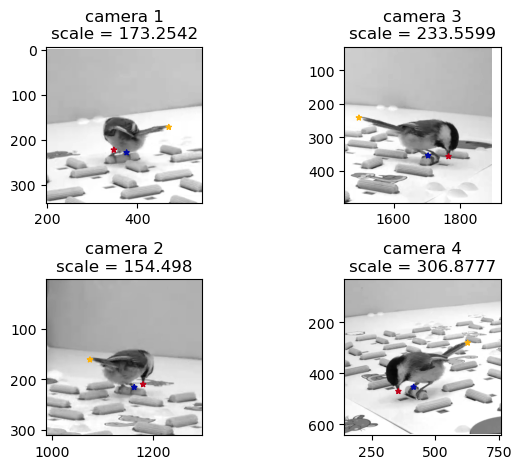

In [9]:
# plot a frame to check output
ex_frame = 2

# fig params
f, ax = plt.subplots(n_cams//2, 2)
colors = ['xkcd:scarlet', 'xkcd:cobalt blue', 'xkcd:saffron']
node_idx = np.asarray([0, 14, 6]) # topBeak, rightFoot, tipTail
# x_idx = np.full(node_idx.shape[0], 0)
# y_idx = np.full(node_idx.shape[0], 1)

# plot for each camera
for n_cam in range(n_cams):
    # get subplot index
    if n_cam < n_cams//2:
        r = n_cam
        c = 0
    else:
        r = n_cam - n_cams//2
        c = 1
    
    # label example keypoints
    while np.isnan(np.sum(labels[ex_frame])):
        ex_frame += 1
    ax[r, c].imshow(images[n_cam][:, :, :, ex_frame], cmap='gray')
    ax[r, c].scatter(labels[ex_frame, n_cam, node_idx, 0], 
                     labels[ex_frame, n_cam, node_idx, 1],
                     c=colors, marker='*', s=15)

    # crop around bird
    centroid = centroids[ex_frame, n_cam]
    cam_scale = w3d * scales[ex_frame, n_cam]    
    ax[r, c].set_title(f'camera {n_cam + 1}\nscale = {np.round(cam_scale, 4)}')
    ax[r, c].set_xlim([centroid[0] - cam_scale, centroid[0] + cam_scale])
    ax[r, c].set_ylim([centroid[1] + cam_scale, centroid[1] - cam_scale])

plt.tight_layout()
plt.show()

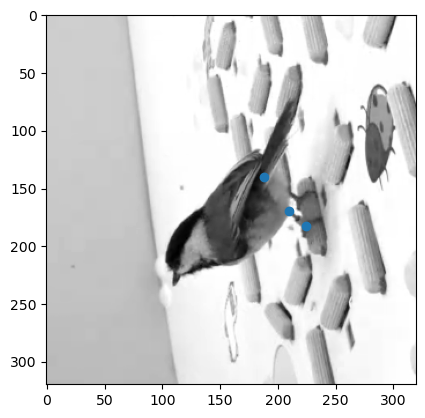

In [25]:
''' concatenate across camera views and crop frames '''
ex_frame = 0
label_data = [] # shape (total_frames, n_nodes, 2)
image_data = [] # shape (total_frames, ds_w, ds_h)

for n_cam in range(n_cams):
    images = np.transpose(all_cams[n_cam], axes=[2, 0, 1]) 
    labels = all_labels[:, n_cam]
    scales = all_scales[:, n_cam]
    centroids = all_centroids[:, n_cam]
    n_frames = labels.shape[0]
    for f in range(n_frames):
        if np.isfinite(labels[f].sum()):
            body_ctr = centroids[f] # rough x-y body coords as in comNet
            half_width = np.round(w3d * scales[f])
            crop_img, min_ind, crop_scale = crop_from_ctr(images[f], 
                                                            body_ctr,
                                                            half_width,
                                                            crop_size)
            crop_ann = (labels[f] - min_ind) * crop_scale
            image_data.append(crop_img.T)
            label_data.append(crop_ann)

label_data = np.asarray(label_data)
image_data = np.asarray(image_data)

plt.imshow(image_data[4], cmap='gray')
plt.scatter(label_data[4, node_idx-1, 1], label_data[4, node_idx-1, 0])

In [20]:
label_data.shape

(28, 15, 2)

In [ ]:
# convert into a SLP project file
create_slp_project(images=image_data, 
                   skeleton_file=skeleton_file,
                   keypoints=label_data,
                   slp_labels_file=slp_project_path)